# Similarity learning with Covalent

In this workshop, you will learn how to use Covalent to manage hybrid quantum-classical workflows for the task of similarity learning. Specfically, within the same workflow, we will dispatch a hybrid quantum-classical machine learning (ML) algorithm and a purely classical ML algorithm to recognize *similar* 2x2 pixel images.

While this is a toy problem, it outlines a crucial workflow used to compare the quality of classical and quantum ML models.

First, let's import the modules we need for this workshop

# Table of contents
1. [Loading and preparing the training and testing datasets](#load_data)

2. [A quick visual introduction to the datasets](#vis_intro)

3. [Classical Siamese networks](#classical_siamese)

4. [Quantum similarity networks](#quantum_similarity)

5. [A heterogeneous workflow: comparing accuracy scores](#heterogeneous_acc)

6. [Investigating learnt notions of similarity in the classical and quantum networks](#similarity_notion)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
from itertools import cycle

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch import optim
import torch.nn.functional as F

import pennylane as qml

import covalent as ct

import os

/Users/jbaker/opt/miniconda3/envs/algo-time-series/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading and preparing the training and testing datasets <a name="load_data"></a>

To begin, it will be useful to locally resolve the path to the relevant datasets shipping with this repository.

In [2]:
base_path = os.getcwd()
pixel_train = "".join([base_path, "/data/pixel_grid/training"])
pixel_test = "".join([base_path, "/data/pixel_grid/testing"])
faces_example = "".join([base_path, "/data/faces/training"])


we need a simple electron to read a dataset from file into the format required for `PyTorch`.

In [3]:
@ct.electron
def file_to_pytorch_transform(file_root_dir, transform_dims=(2, 2)):
    # Load the training dataset
    folder_dataset = datasets.ImageFolder(root=file_root_dir)

    # Resize the images and transform to tensors
    transformation = transforms.Compose([transforms.Resize(transform_dims),
                                     transforms.ToTensor()
                                    ])
    return folder_dataset, transformation

Now with `PyTorch` compatible data, we need to perform some pre-processing to make it suitable for the similarity learning task. That is, we need to produce data tuples $(x, \tilde{x}, y_{x, \tilde{x}})$. To do so, we define the utility class `SimilarityModelDataset`.

In [4]:
class SimilarityModelDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)

        #We need to approximately 50% of images to be in the same class
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #Look untill the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] == img1_tuple[1]:
                    break
        else:

            while True:
                #Look untill a different class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] != img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])

        img0 = img0.convert("L")
        img1 = img1.convert("L")

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1, torch.from_numpy(np.array([int(img1_tuple[1] != img0_tuple[1])], dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

Within an electron, we call an instance of the `SimilarityModelDataset` class.

In [5]:
@ct.electron
def similarity_learning_dataset(folder_dataset, transformation):
    dataset = SimilarityModelDataset(folder_dataset, transformation)
    return dataset

and in a final data-processing step, we create an electron to create a `torch` `DataLoader` object

In [6]:
@ct.electron
def torch_dataloader(dataset, batch_size, shuffle=True):
    dataloader = DataLoader(dataset, shuffle=shuffle, batch_size=batch_size)
    return dataloader

## A quick visual introduction to the datasets <a name="vis_intro"></a>

While the purpose of an electron is to be executed within a `ct.lattice` (i.e as part of a workflow), they can also be executed locally. Let's try a local execution to demonstrate the contents of our training dataset with the context of a more realistic dataset.

torch.float32


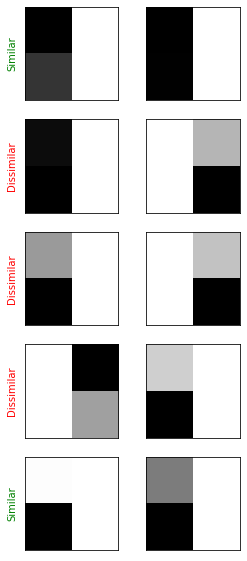

In [7]:
# Load pixels dataset
folder_dataset, transformation = file_to_pytorch_transform(pixel_train)
dataset = similarity_learning_dataset(folder_dataset, transformation)
dataloader_pixels = torch_dataloader(dataset, 1)

# Display a couple of items from the training dataset
fig, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=[4, 10])

iterarable_pixels = iter(dataloader_pixels)
for i in range(5):
    # Pixels first
    x1_pixel, x2_pixel, label_pixel = next(iterarable_pixels)
    axs[i, 0].imshow(x1_pixel[0, 0, :, :], cmap="Greys")
    axs[i, 1].imshow(x2_pixel[0, 0, :, :], cmap="Greys")
    axs[i, 0].set_xticks([]); axs[i, 1].set_xticks([])
    axs[i, 0].set_yticks([]); axs[i, 1].set_yticks([])
    # Display label
    if label_pixel == 1:
        axs[i, 0].set_ylabel('Dissimilar', color="red")
    else:
        axs[i, 0].set_ylabel('Similar', color="green")

It can be seen that images labelled as **similar** ($y_{x \tilde{x}} = 0$) are those sharing a left or right side with zeroed-out pixels. Those which are **dissimilar** ($y_{x \tilde{x}} = 1$)have zeroed-out pixels on opposite sides.

Now in the context of a more realistic dataset...

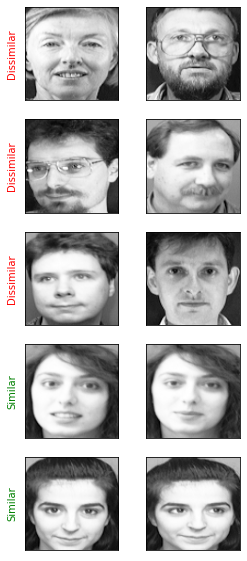

In [8]:
# Load faces dataset
folder_dataset, transformation = file_to_pytorch_transform(faces_example, transform_dims=(100, 100))
dataset = similarity_learning_dataset(folder_dataset, transformation)
dataloader_faces = torch_dataloader(dataset, 1)
iterable_faces = iter(dataloader_faces)

fig, axs = plt.subplots(5, 2, sharex=True, sharey=True, figsize=[4, 10])
for i in range(5):
    # Faces second
    x1_face, x2_face, label_face = next(iterable_faces)
    axs[i, 0].imshow(x1_face[0, 0, :, :], cmap="Greys_r")
    axs[i, 1].imshow(x2_face[0, 0, :, :], cmap="Greys_r")
    axs[i, 0].set_xticks([]); axs[i, 1].set_xticks([])
    axs[i, 0].set_yticks([]); axs[i, 1].set_yticks([])

    # Display label
    if label_face == 1:
        axs[i, 0].set_ylabel('Dissimilar', color="red")
    else:
        axs[i, 0].set_ylabel('Similar', color="green")

Here, things are a little more obvious. If the image is of the same person, they are **similar** ($y_{x \tilde{x}} = 0$). If they display a different person, they are **dissimilar** ($y_{x \tilde{x}} = 1$). It is now clear that an algorithm capable of performing such distinctions is useful in areas like facial recognition.

Anyways, let's proceed with our 2x2 pixel example and devise a classical and quantum algorithm capable of learning these notions of similarity. Let's start classical!

## Classical Siamese networks <a name="classical_siamese"></a>

A classical Siamese network tackles the similarity learning task by jointly training twin (think Siamese...) neural networks using a **contrastive loss**. A typical layout of a Siamese network is shown below.

![A schematic of a classical Siamese network.](./images/siamese_network.png)

Source: <https://www.youtube.com/watch?v=4S-XDefSjTM>

While such networks usually involve dimension reduction of the image (via something like `torch.nn.MaxPool2d`) to create a low-dimensional latent space, we are already working with 2x2 pixel grayscale images so we skip this part. 

Lets create a `PyTorch` network involing convolutional and linear layers.

In [9]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()

        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 2, kernel_size=2, stride=1, padding='same', padding_mode="zeros"),
            nn.ReLU(inplace=True),
            # Maxpooling here if image was larger dimensions...
            
            nn.Conv2d(2, 4, kernel_size=2, stride=1, padding='same', padding_mode="zeros"),
            nn.ReLU(inplace=True),
            # Maxpooling here if image was larger dimensions...

            nn.Conv2d(4, 8, kernel_size=2, stride=1, padding='same', padding_mode="zeros"),
            nn.ReLU(inplace=True)
        )

        # Setting up the Sequential of Fully Connected linear Layers
        self.fc1 = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(inplace=True),
            
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            
            nn.Linear(32, 2)
        )
        
    def forward_once(self, x):
        # This function will be called for both images
        # Its output is used to determine the raw (pre sigmoidal) similiarity
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # In this function we pass in both images and obtain both vectors
        # which are returned
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        return output1, output2

We now have a network which outputs a latent vector upon insertion of an image. Now, in a Siamese network, we require comparison of the latent vector upon insertion of two different images $x$ and $\tilde{x}$. This defines the contrastive loss. Let's make a class.

In [10]:
class ClassicalContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ClassicalContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Calculate the euclidean distance and calculate the contrastive loss
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim=True)

        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
    

        loss_contrastive = 2*(torch.sigmoid(loss_contrastive) - 0.5) # Mean square loss is positive. Rescale in 0 1
        return loss_contrastive

and a corresponding electron to create a `ClassicalContrastiveLoss` instance

In [11]:
@ct.electron
def classical_contrastive_loss(margin=2):
    contrastive_loss = ClassicalContrastiveLoss(margin)
    return contrastive_loss

We're nearly there! We need an electron to train the network.

In [12]:
@ct.electron
def train_classical_siamese_network(train_dataloader, torch_optim, lr, loss_function, epochs, print_intermediate=False):
    
    # Create network instance here
    network = SiameseNetwork()
    optimizer = torch_optim(network.parameters(), lr)
    loss_history = [] 

    # Outer training loop
    for epoch in range(epochs):

        # Iterate over batches
        for i, (img1, img2, label) in enumerate(train_dataloader, 0):

            # Images and labels
            img1, img2, label = img1.cpu(), img2.cpu(), label.cpu()

            # Zero the gradients
            optimizer.zero_grad()

            # Pass in the two images into the network and obtain two outputs
            output1, output2 = network.cpu()(img1, img2)

            # Pass the outputs of the networks and label into the loss function
            loss_contrastive = loss_function(output1, output2, label)

            # Calculate the backpropagation
            loss_contrastive.backward()

            # Optimize
            optimizer.step()

            # Loss appended at the end of each batch
            loss_history.append(loss_contrastive.item())

            # Every 10 epochs print out the loss
        if print_intermediate:
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
    return network, loss_history

and and electron to get the simlarity between unseen images and return a prediction.

In [13]:
@ct.electron
def get_similarity(x1, x2, trained_net):
    output1, output2 = trained_net(x1.cpu(), x2.cpu())
    euclidean_distance = F.pairwise_distance(output1, output2)
    scaled_dist = 2*(torch.sigmoid(euclidean_distance) - 0.5)
    prediction = torch.round(scaled_dist)
    return scaled_dist, prediction

In [14]:
@ct.electron
def get_testing_results(dataloader_test, trained_net, num_dat=None):
    results = []
    iterable = iter(dataloader_test)
    if num_dat is None:
        num_dat = len(dataloader_test.dataset)
    for i in range(num_dat):
        x1, x2, label = next(iterable)
        scaled_dist, prediction = get_similarity(x1, x2, trained_net)
        results.append([label.item(), prediction.item(), scaled_dist.item()])
    return results

Now it's time to construct a simple exemplar workflow. We shall load the training and testing data, perform preprocessing, train the network and see how predictions line up with the ground truth for 5 elements of the testing dataset.

In [15]:
@ct.lattice
def classical_workflow(train_path, test_path, train_batch, pytorch_optimizer, epochs, lr, print_intermediate, test_num_dat):

    # Load training dataset
    folder_dataset, transformation = file_to_pytorch_transform(train_path)
    dataset = similarity_learning_dataset(folder_dataset, transformation)
    dataloader_train = torch_dataloader(dataset, train_batch)

    # Load testing dataset
    folder_dataset, transformation = file_to_pytorch_transform(test_path)
    dataset = similarity_learning_dataset(folder_dataset, transformation)
    dataloader_test = torch_dataloader(dataset, 1)

    # Siamese network initialization
    contrastive_loss = classical_contrastive_loss()

    # Train the network
    trained_net, loss_history = train_classical_siamese_network(torch_optim=pytorch_optimizer,#torch.optim.Adam,
                                                               train_dataloader=dataloader_train,
                                                               loss_function=contrastive_loss,
                                                               epochs=epochs,
                                                               print_intermediate=print_intermediate, lr=lr)
    
    # Perform predictions on testing data with the trained network
    results = get_testing_results(dataloader_test, trained_net, num_dat=test_num_dat)
    
    return results, loss_history, trained_net

For the first time, let's launch the covalent server. Launch from your terminal and purge:
covalent start --ignore-migrations
`covalent purge --hell yeah`, `covalent start`

In [17]:
dispatch_id = ct.dispatch(classical_workflow)(train_path=pixel_train,
                                              test_path=pixel_test,
                                              train_batch=8,
                                              pytorch_optimizer=torch.optim.Adam,
                                              epochs=5,
                                              lr=0.005,
                                              print_intermediate=False,
                                              test_num_dat=5)
ct_results = ct.get_result(dispatch_id=dispatch_id, wait=True)

Check for the success of the workflow. Navigate to <http://localhost:48008/> to view the GUI.

In [18]:
results, loss_history, trained_net = ct_results.result

Text(0, 0.5, 'Classical loss')

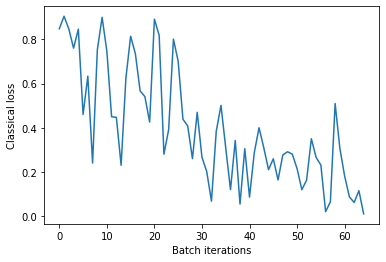

In [19]:
plt.plot(loss_history)
plt.xlabel('Batch iterations')
plt.ylabel('Classical loss')

## Quantum similarity networks <a name="quantum_similarity"></a>

Same workflow as Siamese network, but using a quantum cost function

In [20]:
dev = qml.device('lightning.qubit', wires=5)

@ct.electron
@qml.qnode(dev, interface='torch')
def similarity_circuit(x1, x2, alpha1, alpha2, wires, ansatz=qml.QAOAEmbedding, measure_bits=2):
    # Basically a kernel
    ansatz(features=x1, weights=alpha1, wires=wires)
    qml.adjoint(ansatz)(features=x2, weights=alpha2, wires=wires)
    # Measure only first measure_bits qubits.
    return [qml.expval(qml.PauliZ(i)) for i in range(measure_bits)]

In [21]:
@ct.electron
def quantum_cost(batch, alpha1, alpha2, wires, similarity_circuit, measure_bits=2):
    x1_batch, x2_batch, label_batch = batch
    batch_size = len(x1_batch)
    all_costs = torch.zeros(batch_size)
    for i in range(batch_size):

        x1 = torch.flatten(x1_batch[i]) # embedding requires flat tensor
        x2 = torch.flatten(x2_batch[i])
        label = label_batch[i]

        expecs = similarity_circuit(x1, x2, alpha1, alpha2, wires, ansatz=qml.QAOAEmbedding, measure_bits=measure_bits)
        dist = (torch.mean(expecs) + 1)/2 # Now in 0 - 1
        loss_contrastive = (1-label) * torch.pow(dist, 2) +\
                       (label) * torch.pow(torch.clamp(0.9 - dist, min=0.0), 2)
        all_costs[i] = loss_contrastive
    avg_loss = torch.mean(all_costs)
    return avg_loss

In [22]:
@ct.electron
def get_random_init_params(n_qubits, layers, ansatz=qml.QAOAEmbedding):
    alpha1 = torch.tensor(np.random.uniform(size=ansatz.shape(layers, n_qubits)), requires_grad=True)
    alpha2 = torch.tensor(np.random.uniform(size=ansatz.shape(layers, n_qubits)), requires_grad=True)
    return alpha1, alpha2

In [23]:
@ct.electron
def train_quantum_net(lr, init_params, dataloader_train, batch_cost_func, similarity_circuit,
                      measure_bits, epochs, pytorch_optimizer, print_intermediate=False):

    opt = pytorch_optimizer(init_params, lr=lr)
    dataiter = iter(dataloader_train)
    alpha1, alpha2 = init_params

    def closure():
        opt.zero_grad()
        loss = batch_cost_func(next(dataiter), alpha1, alpha2, 
                               similarity_circuit=similarity_circuit,
                               wires=dev.wires, measure_bits=measure_bits)
        loss.backward()
        return loss
    
    loss_history = [] 
    for epoch in range(epochs):
        dataiter = iter(dataloader_train)
        for i in range(len(dataloader_train)):
            loss = opt.step(closure)
            loss_history.append(loss.item()) 
        if epoch % 10 == 0 and print_intermediate:
            print(f"Epoch number {epoch}\n Current loss {loss.item()}\n")
    return loss_history, opt

In [24]:
@ct.electron
def get_quantum_prob(x1, x2, label, alpha1, alpha2, wires, similarity_circuit, ansatz=qml.QAOAEmbedding, measure_bits=2):
    x1 = torch.flatten(x1) # embedding requires flat tensor
    x2 = torch.flatten(x2)
    expecs = similarity_circuit(x1, x2, alpha1, alpha2, wires, ansatz=ansatz, measure_bits=measure_bits)
    dist = (torch.mean(expecs) + 1)/2 # Now in 0 - 1
    return dist

@ct.electron
def quantum_predict(quantum_prob):
    return torch.round(quantum_prob)

In [25]:
@ct.electron
def get_test_results_quantum(dataloader_test, opt_params, prob_func, predict_func, wires, measure_bits, num_dat=None):
    # pass a dataloader with 1 batch size to cycle through testing
    alpha1, alpha2 = opt_params
    iterable = iter(dataloader_test)
    results = []
    if num_dat is None:
        num_dat = len(dataloader_test.dataset)
    for i in range(num_dat):
        x1, x2, label = next(iterable)
        x1 = torch.flatten(x1) # embedding requires flat tensor
        x2 = torch.flatten(x2)

        prob = prob_func(x1, x2, label, alpha1, alpha2, wires, similarity_circuit, ansatz=qml.QAOAEmbedding, measure_bits=2)
        prediction = predict_func(prob)
        results.append([label.item(), prediction.item(), prob.item()])
    return results

In [26]:
@ct.lattice
def quantum_workflow(train_path, test_path, train_batch, pytorch_optimizer, epochs, lr, print_intermediate, test_num_dat):

    # Get training and testing dataloaders
    folder_dataset, transformation = file_to_pytorch_transform(train_path)
    dataset = similarity_learning_dataset(folder_dataset, transformation)
    dataloader_train = torch_dataloader(dataset, train_batch)

    folder_dataset, transformation = file_to_pytorch_transform(test_path)
    dataset = similarity_learning_dataset(folder_dataset, transformation)
    dataloader_test = torch_dataloader(dataset, 1)

    # Get intial parameters for quantum net. We hardcode the 5 qubit 2 layer QAOA ansatz.
    alpha1, alpha2 = get_random_init_params(5, 2)

    # pass relevant electron functions to training routine. Measure_bits=2 is also hardcoded
    loss_history, opt = train_quantum_net(lr=lr, init_params=[alpha1, alpha2],
                                          dataloader_train=dataloader_train,
                                          batch_cost_func=quantum_cost, # is an electron function
                                          similarity_circuit=similarity_circuit, # is an electron function
                                          measure_bits=2, epochs=epochs,
                                          pytorch_optimizer=pytorch_optimizer,
                                          print_intermediate=False)
    results = get_test_results_quantum(dataloader_test, opt.param_groups[0]['params'],
                                       prob_func=get_quantum_prob, 
                                       predict_func=quantum_predict,
                                       wires=dev.wires,
                                       measure_bits=2, num_dat=test_num_dat)
    return results, loss_history, opt
    

In [27]:
dispatch_id = ct.dispatch(quantum_workflow)(train_path=pixel_train,
                                            test_path=pixel_test,
                                            train_batch=8,
                                            pytorch_optimizer=torch.optim.Adam,
                                            epochs=5,
                                            lr=0.05,
                                            print_intermediate=False,
                                            test_num_dat=5)
wf_results = ct.get_result(dispatch_id=dispatch_id, wait=True)

In [28]:
results, loss_history, trained_opt = wf_results.result

Text(0, 0.5, 'Quantum loss')

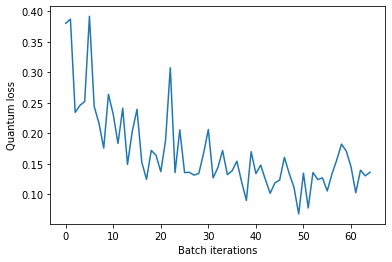

In [29]:
plt.plot(loss_history)
plt.xlabel("Batch iterations")
plt.ylabel("Quantum loss")

## A heterogeneous workflow: comparing accuracy scores <a name="heterogeneous_acc"></a>

Compare the accuracy scores upon testing for the quantum and classical model.

In [62]:
@ct.electron
def get_accuracy_score(results_tuples):
    # Process the (label, prob, prediciton) tuple and return an accuracy percentage
    correct_counter = 0
    for result in results_tuples:
        if result[0] == result[1]: # Label matches prediction
            correct_counter += 1
        else:
            continue
    return 100*correct_counter/len(results_tuples)

In [63]:
@ct.lattice
def quantum_classical_workflow(train_path, test_path, train_batch, pytorch_optimizer, epochs, lr_c, lr_q, print_intermediate):

    # Run the classical sublattice
    results_classical, loss_history_classical, trained_net_c = \
         classical_workflow(train_path=pixel_train,
                            test_path=pixel_test,
                            train_batch=train_batch,
                            pytorch_optimizer=pytorch_optimizer,
                            epochs=epochs,
                            lr=lr_c,
                            print_intermediate=print_intermediate,
                            test_num_dat=None)

    # Run the quantum sublattice
    results_quantum, loss_history_quantum, trained_opt_q = \
         quantum_workflow(train_path=train_path,
                          test_path=test_path,
                          train_batch=train_batch,
                          pytorch_optimizer=pytorch_optimizer,
                          epochs=epochs,
                          lr=lr_q,
                          print_intermediate=print_intermediate,
                          test_num_dat=None)

    # Calculate the accuracy scores
    acc_classical = get_accuracy_score(results_classical)
    acc_quantum = get_accuracy_score(results_quantum)
    return (acc_classical, acc_quantum, trained_net_c, trained_opt_q,
            loss_history_classical, loss_history_quantum, results_quantum, results_classical)

In [64]:
# Expect this to take a few minutes (~8 minutes on an M1 mac)
dispatch_id = ct.dispatch(quantum_classical_workflow)(train_path=pixel_train,
                                                      test_path=pixel_test,
                                                      train_batch=8,
                                                      pytorch_optimizer=torch.optim.Adam,
                                                      epochs=25,
                                                      lr_q=0.05,
                                                      lr_c=0.0005,
                                                      print_intermediate=False)
wf_results = ct.get_result(dispatch_id=dispatch_id, wait=True)

In [65]:
acc_classical, acc_quantum, trained_net_c, trained_opt_q, loss_history_classical,\
     loss_history_quantum, results_quantum, results_classical = \
     wf_results.result

In [66]:
print("Accuracy score for classical Siamese network:", acc_classical, "%")
print("Accuracy score for quantum similarity network:", acc_quantum, "%")

Accuracy score for classical Siamese network: 100.0 %
Accuracy score for quantum similarity network: 89.0 %


Text(0, 0.5, 'Loss')

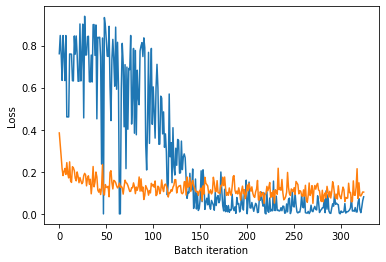

In [67]:
plt.plot(loss_history_classical, label="Classical Siamese network")
plt.plot(loss_history_quantum, label="Quantum similarity network")
plt.xlabel('Batch iteration')
plt.ylabel('Loss')

## Investigating learnt notions of similarity in the classical and quantum networks <a name="similarity_notion"></a>

In [68]:
@ct.electron
def generate_left_right_transition(num_images):
    image_pairs = []
    left_image = torch.tensor([[[1.0, 0],
                               [1.0, 0]]], requires_grad=False, dtype=torch.float32)
    for intensity in torch.tensor(np.linspace(0, 1, num_images), requires_grad=False, dtype=torch.float32):
        image = torch.tensor([[[1.0-intensity, intensity],
                              [1.0-intensity, intensity]]], requires_grad=False, dtype=torch.float32)
        image_pairs.append([left_image, image, 0]) # 2 is the label; different on purpose to previous
    return image_pairs

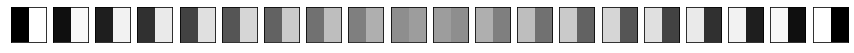

In [69]:
image_pairs = generate_left_right_transition(20)
fig, axs = plt.subplots(1, 20, figsize=[15, 2])
for i, image_pair in enumerate(image_pairs):
    axs[i].imshow(image_pair[1][0], vmin=0, vmax=1, cmap="Greys")
    axs[i].set_yticks([]); axs[i].set_xticks([])

In [70]:
@ct.lattice
def similarity_experiment(num_images, trained_net_c, trained_opt_q):
    image_pairs = generate_left_right_transition(num_images)
    dataloader_test = torch_dataloader(image_pairs, shuffle=False, batch_size=1)
    results_c = get_testing_results(dataloader_test, trained_net)
    results_q = get_test_results_quantum(dataloader_test, trained_opt_q.param_groups[0]['params'],
                                         prob_func=get_quantum_prob, 
                                         predict_func=quantum_predict,
                                         wires=dev.wires,
                                         measure_bits=2)
    return results_c, results_q
    

In [71]:
dispatch_id = ct.dispatch(similarity_experiment)(num_images=20, trained_net_c=trained_net_c, trained_opt_q=trained_opt_q)
ct_results = ct.get_result(dispatch_id=dispatch_id, wait=True)
results_c, results_q = ct_results.result

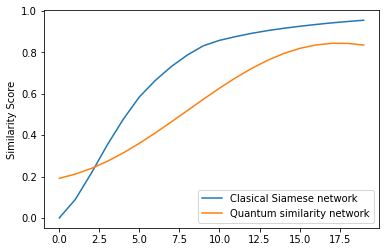

In [72]:
plt.plot([results_c[i][2] for i in range(len(results_c))], label="Clasical Siamese network")
plt.plot([results_q[i][2] for i in range(len(results_q))], label="Quantum similarity network")
plt.ylabel('Similarity Score')
plt.legend()
